In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown1' / Hex(Int8ub),
    'unknown2' / Int8ub,
    'unknown3' / Hex(Int8ub),
    'unknown4' / Hex(Int8ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 Spacecraft ID {sc} APID {apid} Virtual channel {vc}")

def get_packet_timestamps(packets):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array([p[1] for p in packets])

Here we look at some Chang'e 5 low data rate telemetry received with Allen Telescope array on 2021-01-02, during its transfer to the Sun-Earth L1 point. The recorded data corresponds to the frequency 8471.2 MHz, which corresponds to the lander.

The frames are CCSDS concatenated frames with a frames size of 220 bytes.

In [5]:
def load_frames(path):
    frame_size = 220
    frames = np.fromfile(path, dtype = 'uint8')
    frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
    return frames

In [6]:
frames = load_frames('ATA_2021-01-02/ce5_frames_1.u8')

## AOS frames

AOS frames come from spacecraft 91 and virtual channels 1 and 2. Other combinations are most likely to corruted frames despite the fact that the Reed-Solomon decoder was successful.

In [7]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [8]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 2933, 3: 1})

In [9]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({108: 2933})

In [10]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1
                    and a.primary_header.spacecraft_id == 108])

Counter({1: 2933})

## Virtual channel 1

The vast majority of frames belong to virtual channel 1, which seems to send real-time telemetry.

In [11]:
[a.primary_header for a in aos if a.primary_header.virtual_channel_id == 1][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=2622352, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=2622353, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=2622354, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=2622355, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=108, virtual_channel_id=1, virtual_channel_frame_count=2622356, replay_flag=False, vc_frame_co

In [12]:
vc1 = [a for a in aos if a.primary_header.virtual_channel_id == 1]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in vc1])
[a.insert_zone for a in aos[:10]]

[Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815577),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815585),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815593),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815601),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815609),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815617),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815625),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815633),
 Container(unknown1=135, unknown2=105, unknown3=50, unknown4=1, timestamp=265815641),
 Container(unknown1=135, unknown2=105, unknown3=51, unknown4=1, timestamp=265815649)]

In [13]:
t_vc1 = np.datetime64('2012-08-01') + np.timedelta64(1, 's') * np.array([a.insert_zone.timestamp for a in vc1])

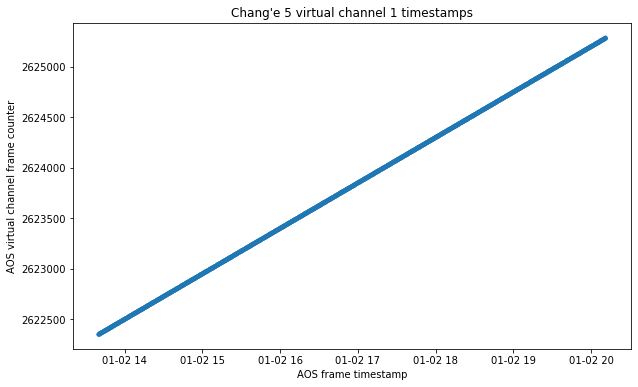

In [14]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t_vc1, fc, '.')
plt.title("Chang'e 5 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

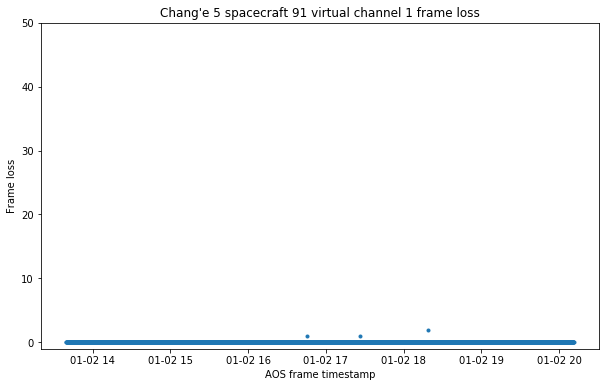

In [15]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t_vc1[1:], np.diff(fc)-1, '.')
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Frame loss')
plt.ylim((-1,50));

We need to sort the data, since the different files we've loaded up are not in chronological order.

In [16]:
vc1_packets = list(ccsds.extract_space_packets(vc1, 108, 1, get_timestamps = True))

../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 2623741, current frame count 2623743
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 2624053, current frame count 2624055
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 108 VC 1] Broken stream. Last frame count 2624444, current frame count 2624447
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


In [17]:
vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in vc1_packets]

There are space packets in may APIDs. The contents of each APID are shown belown in plot form, but it's not easy to guess what any of the values mean.

In [18]:
vc1_apids = collections.Counter([p.APID for p in vc1_sp_headers])
vc1_apids

Counter({40: 2933,
         1030: 1471,
         52: 954,
         5: 620,
         11: 332,
         13: 611,
         14: 604,
         27: 326,
         41: 1098,
         42: 718,
         28: 592,
         33: 579,
         49: 540,
         29: 325,
         39: 311,
         43: 711,
         1040: 537,
         1034: 86,
         7: 172,
         31: 172,
         34: 320,
         35: 169,
         51: 303,
         4: 172,
         30: 171,
         48: 164,
         50: 87,
         2: 88,
         3: 88,
         1031: 86,
         1032: 86,
         1039: 85,
         58: 44,
         16: 44,
         25: 44,
         26: 44,
         1029: 43,
         6: 44,
         60: 43,
         12: 22})

In [19]:
vc1_by_apid = {apid : [p for h,p in zip(vc1_sp_headers, vc1_packets)
                           if h.APID == apid] for apid in vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


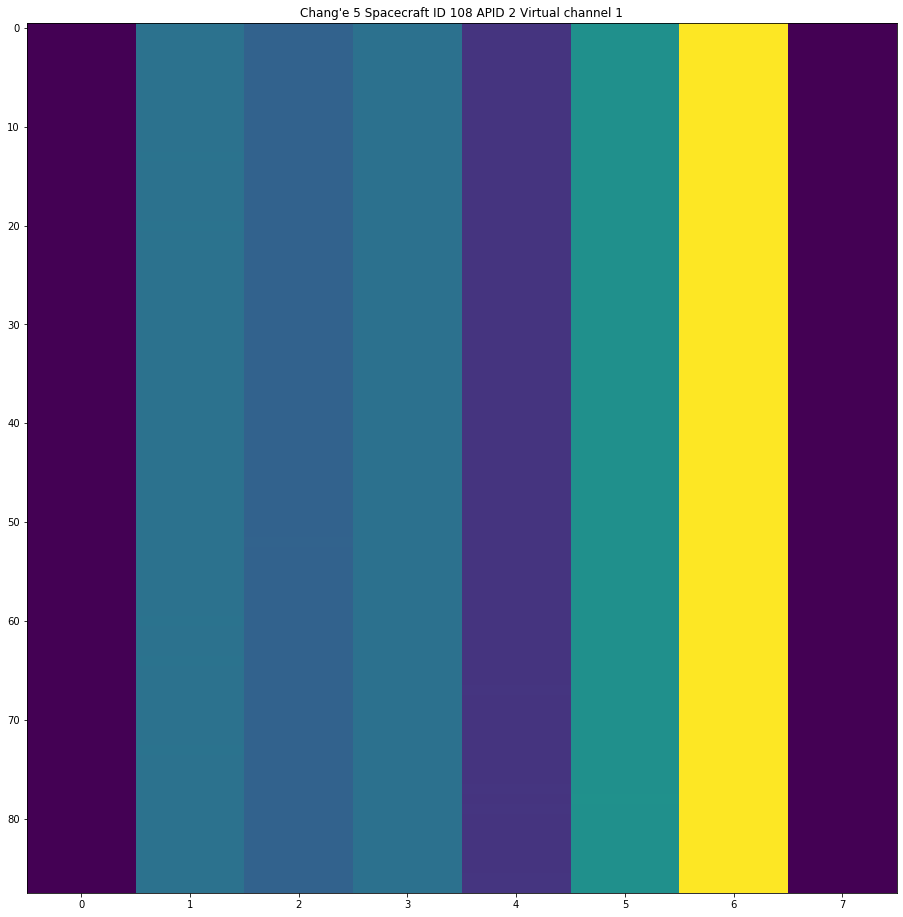

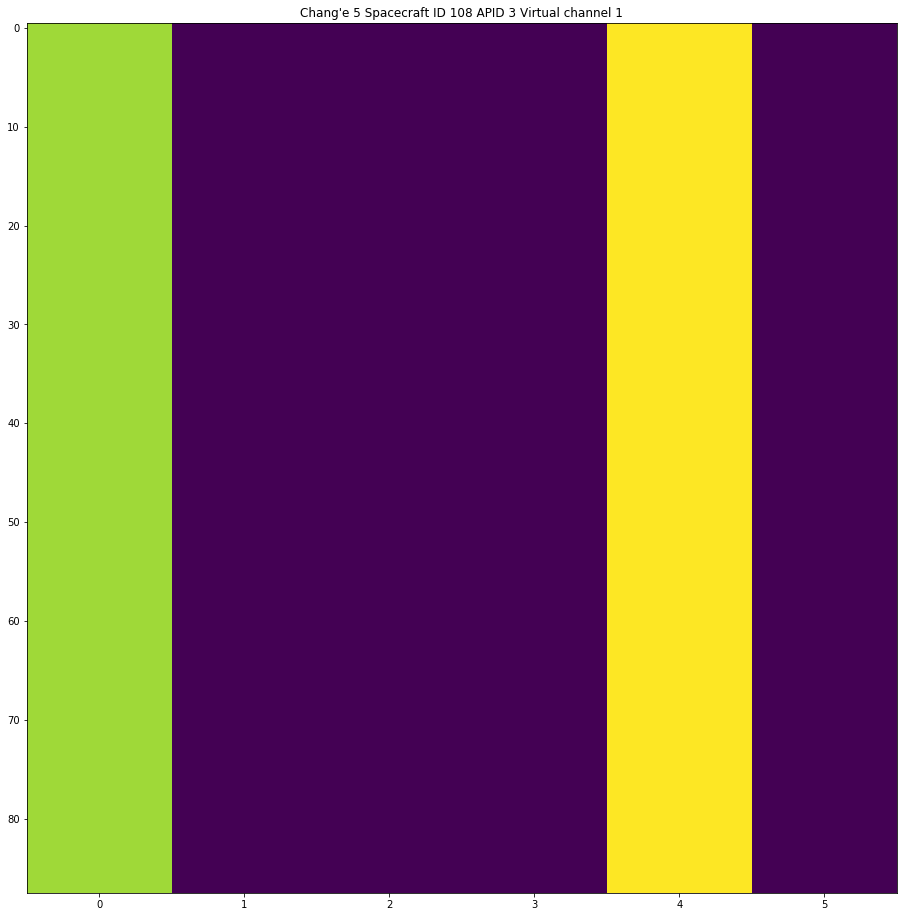

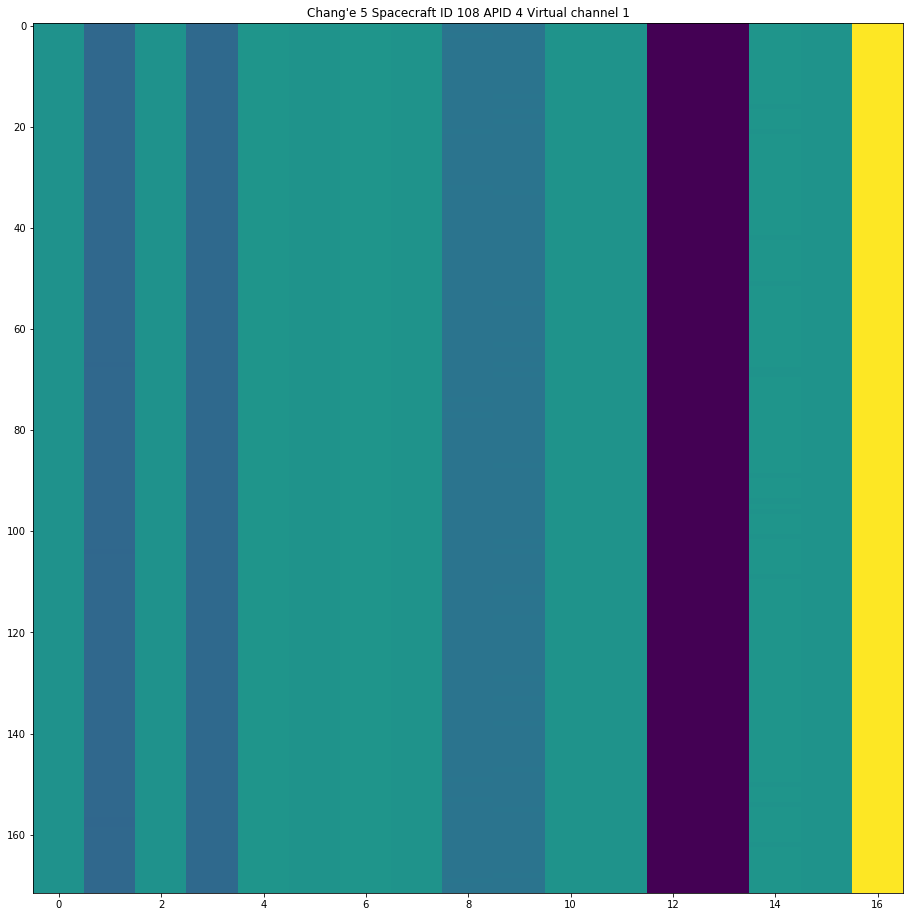

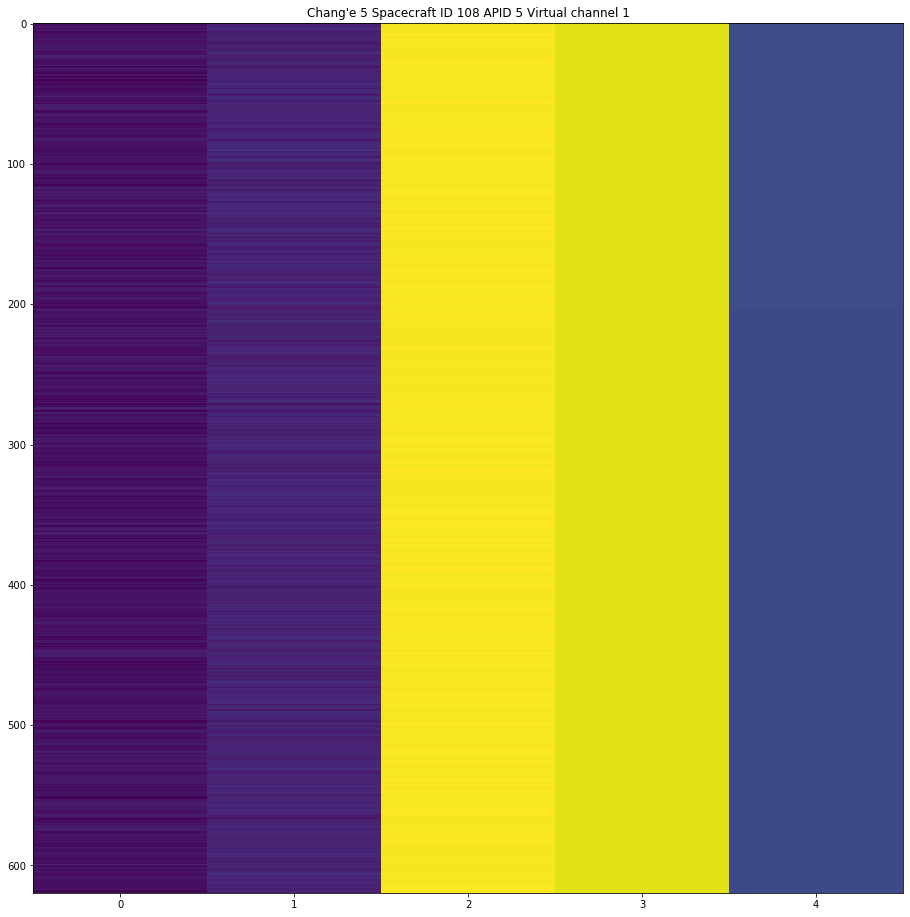

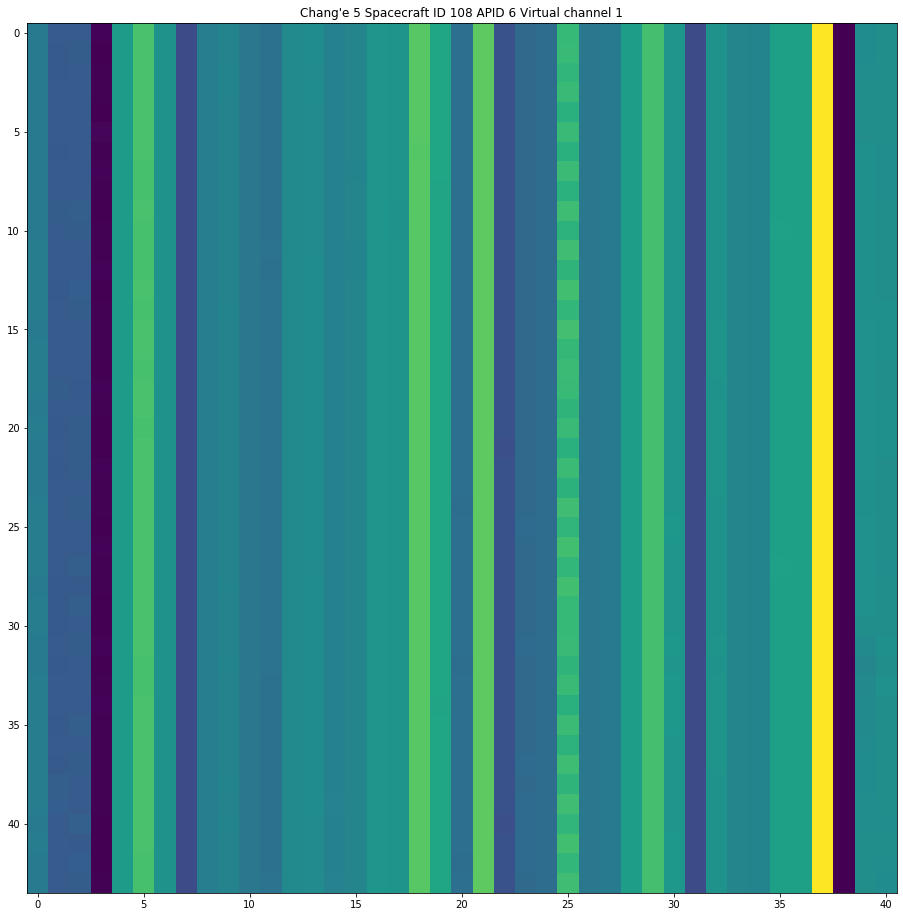

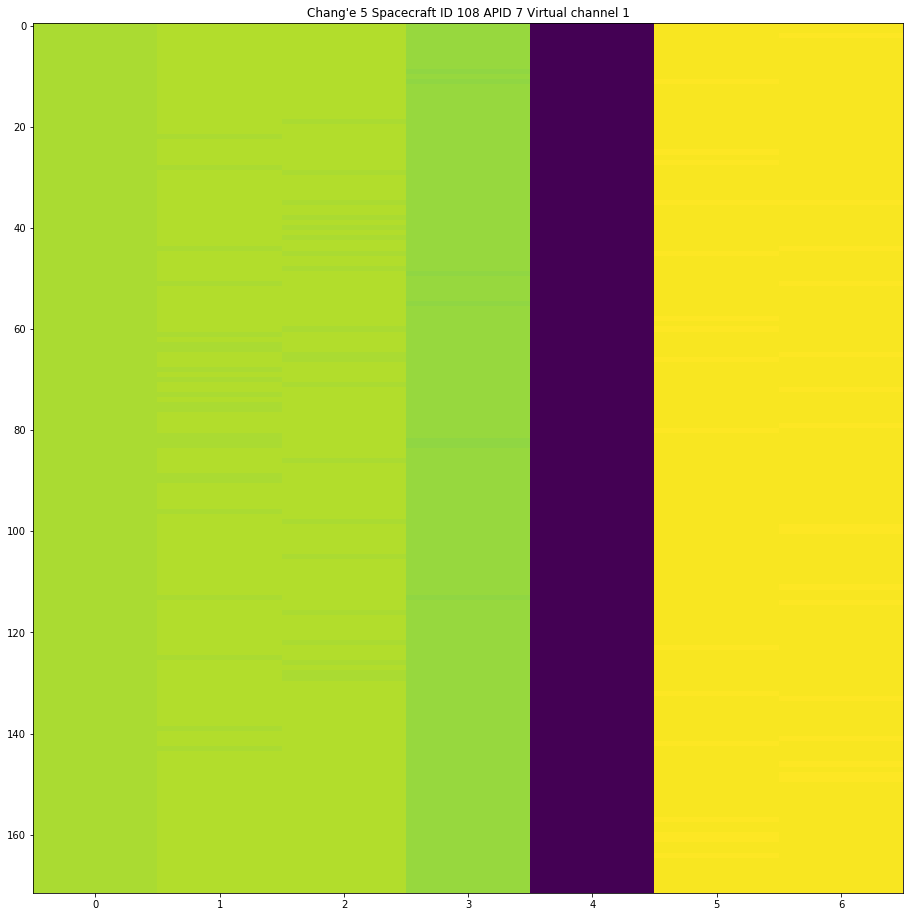

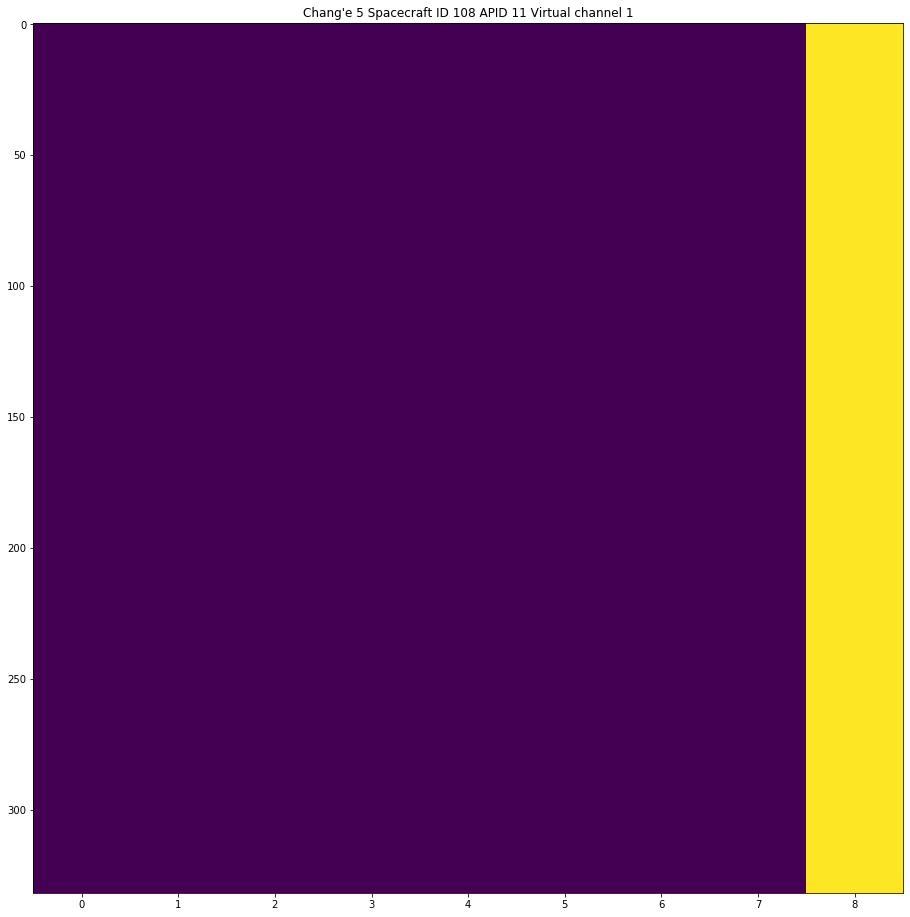

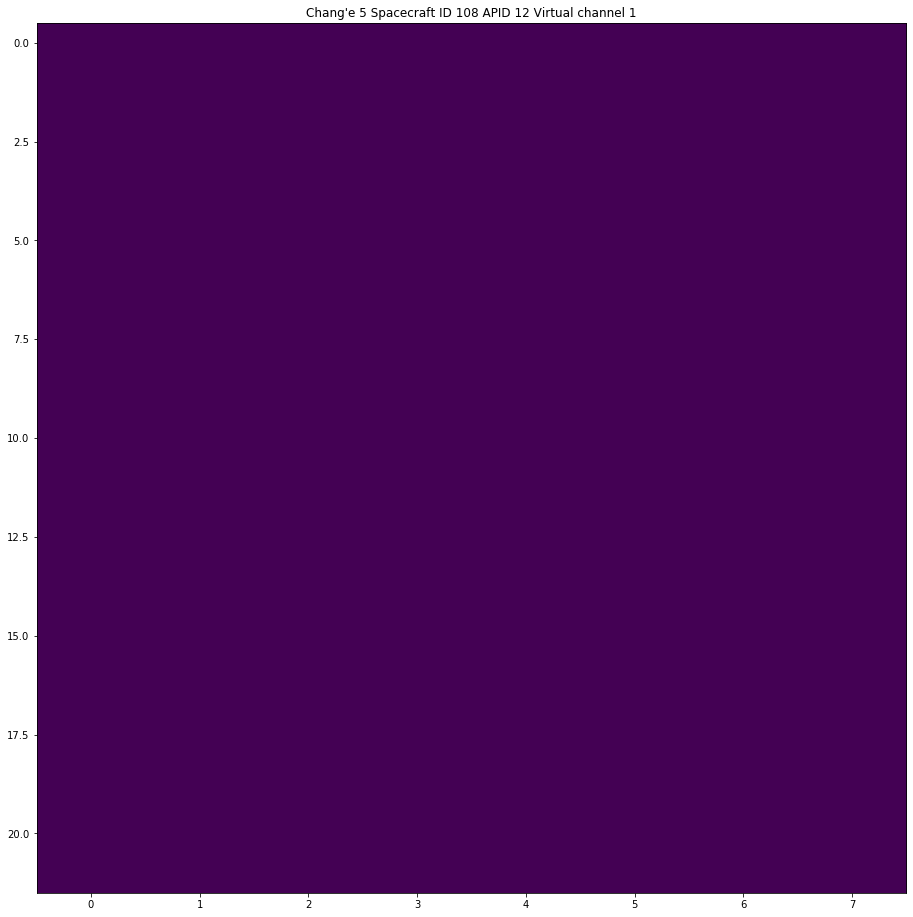

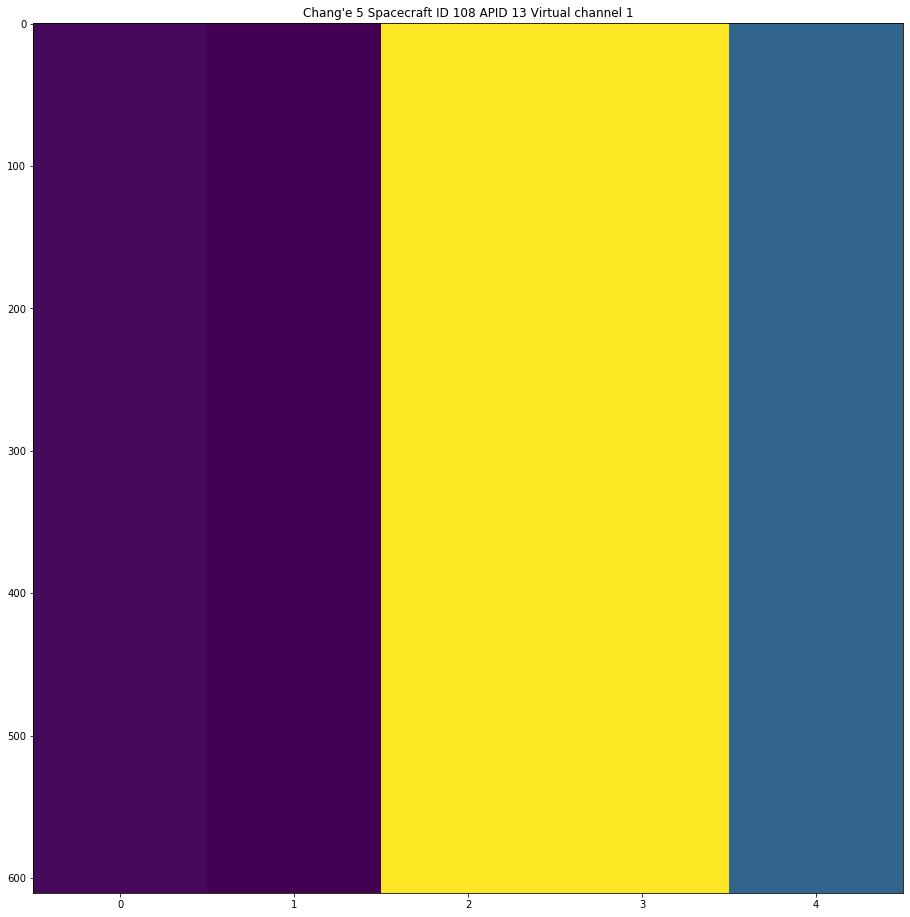

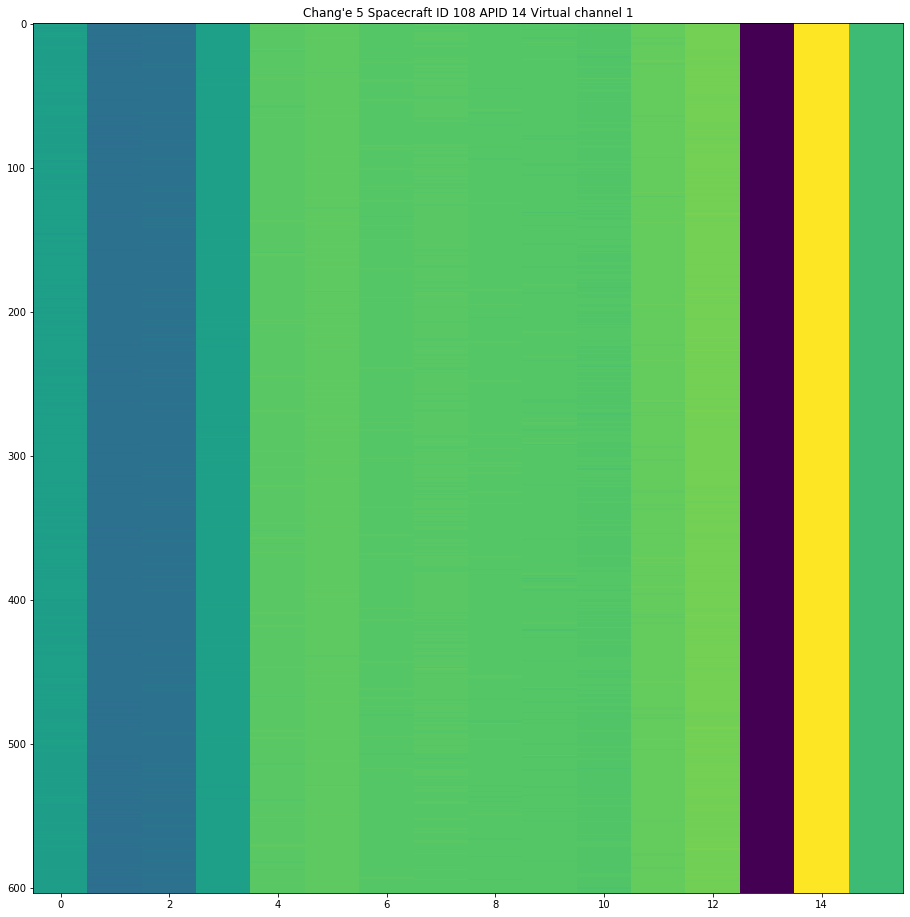

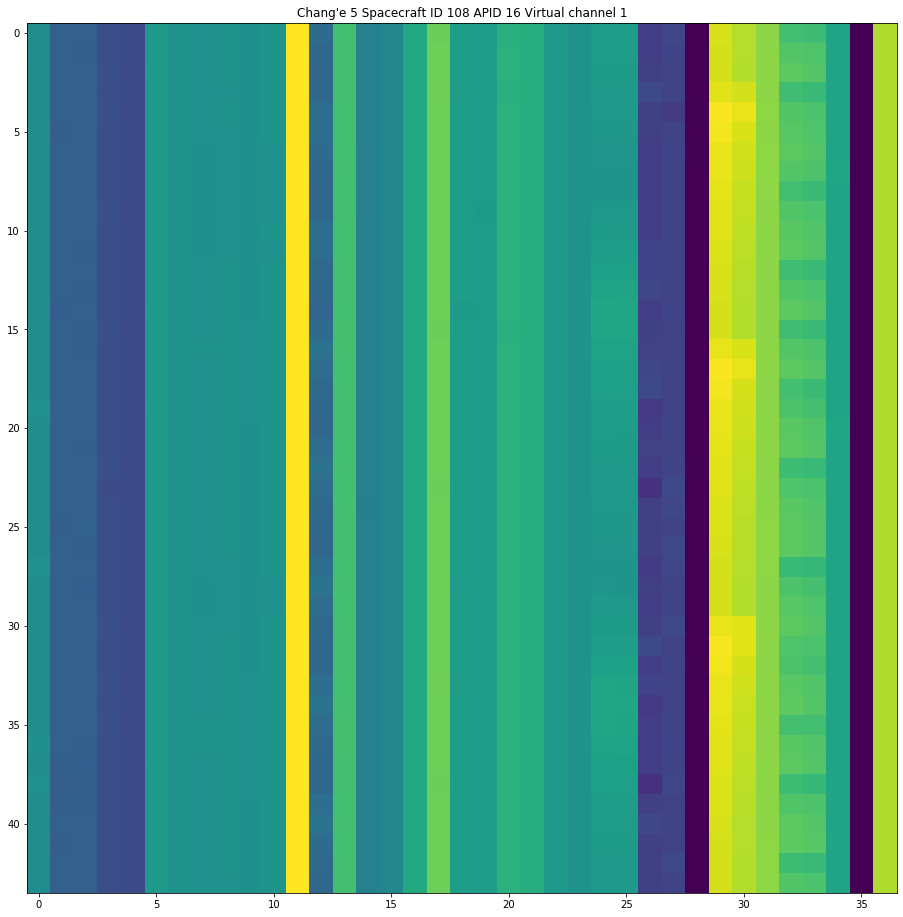

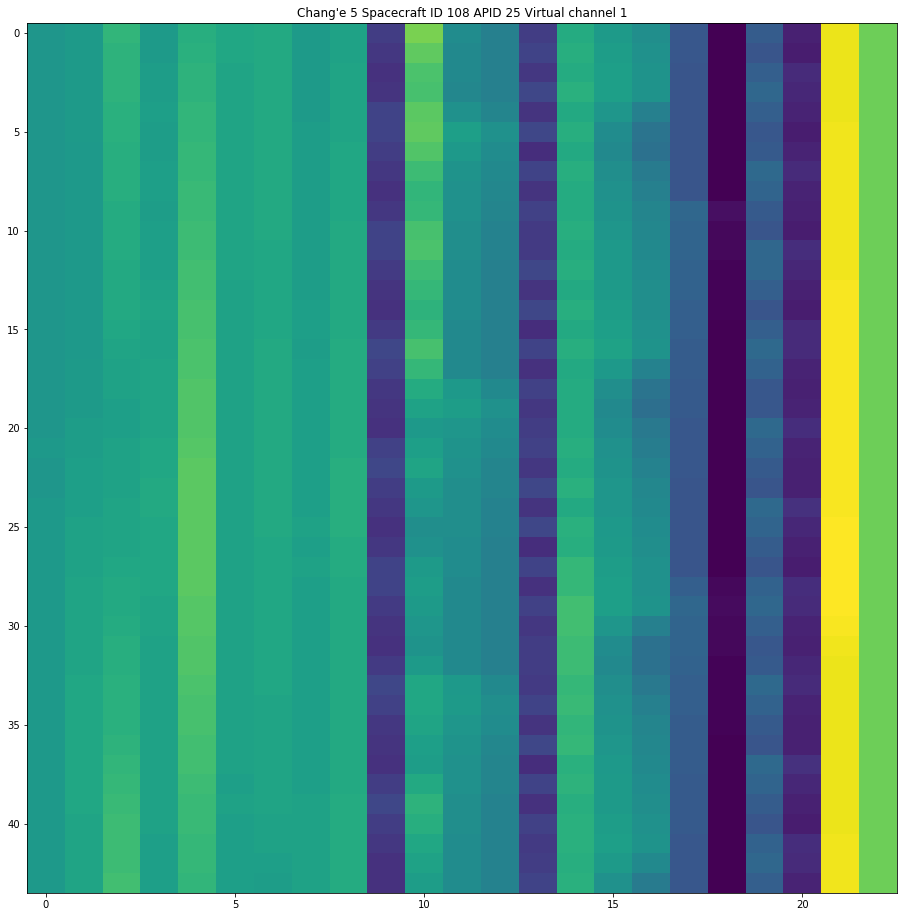

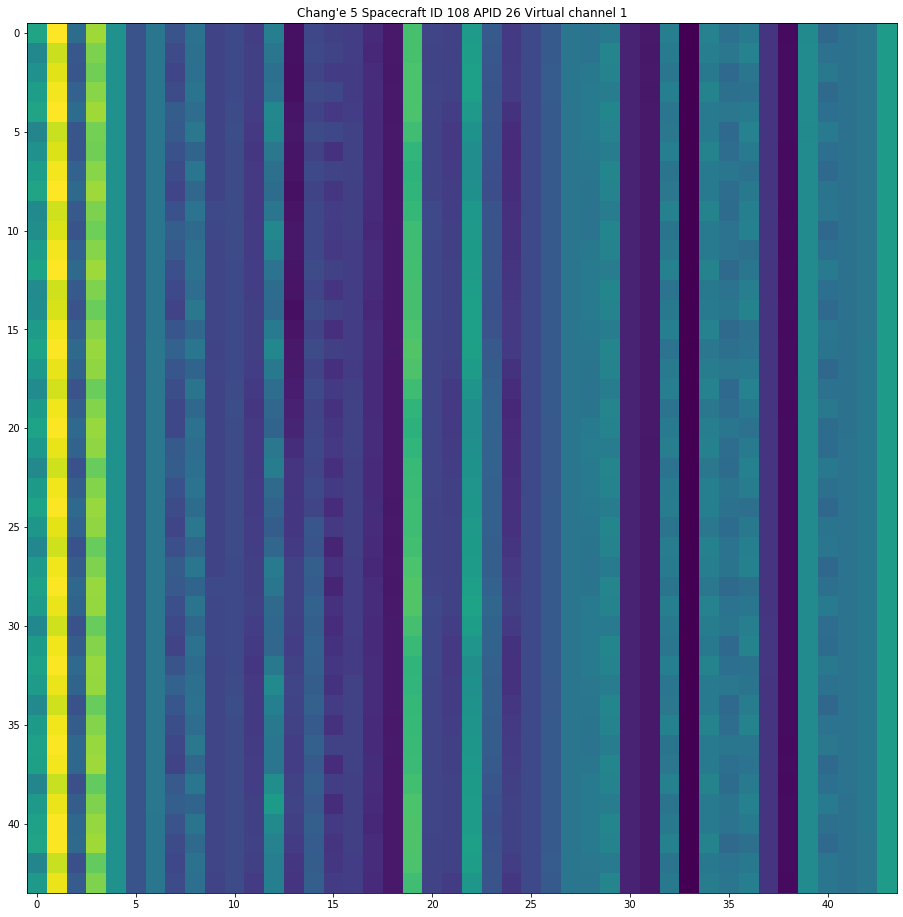

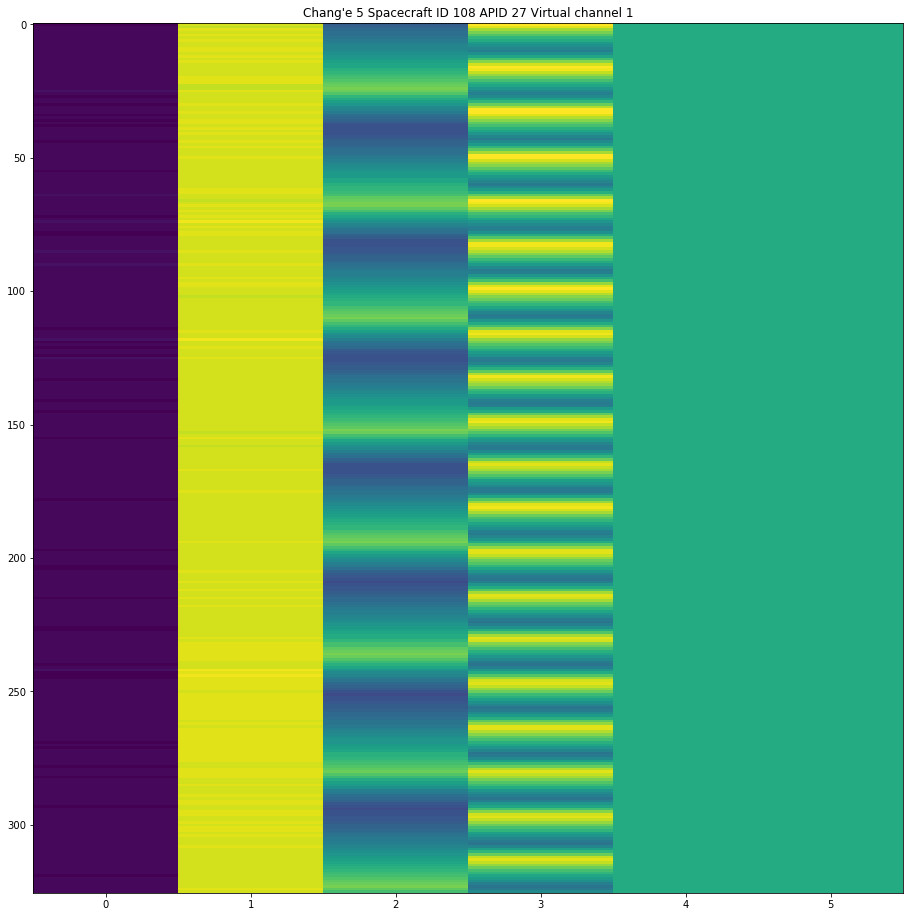

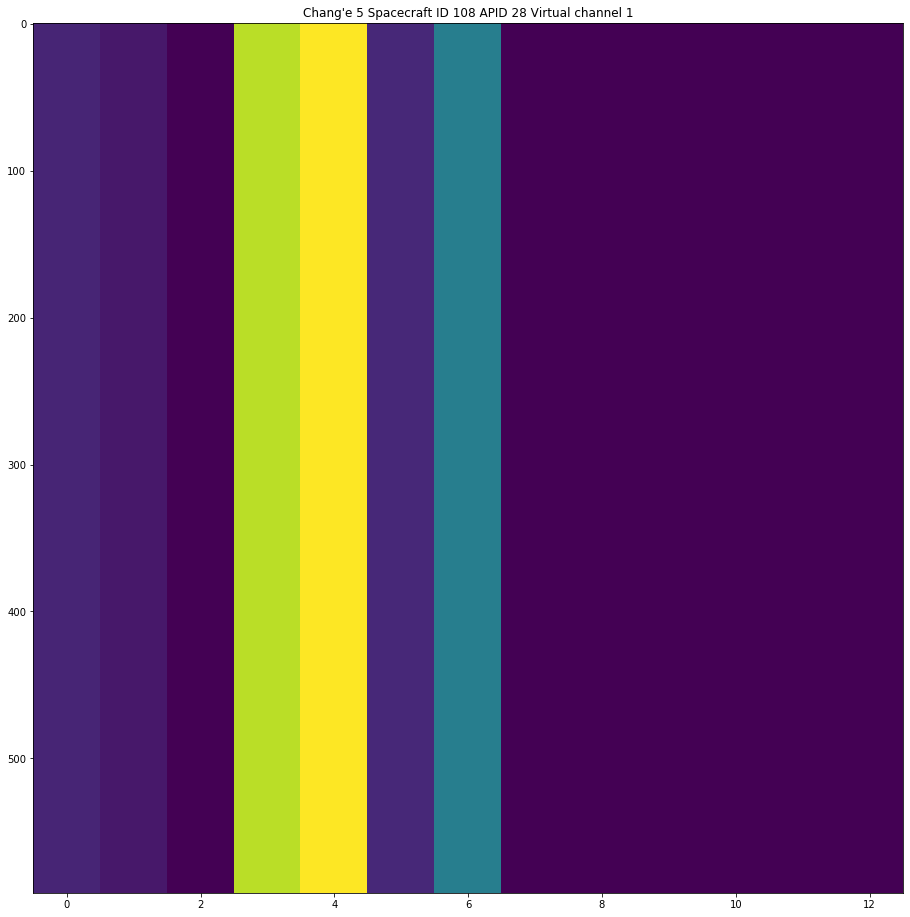

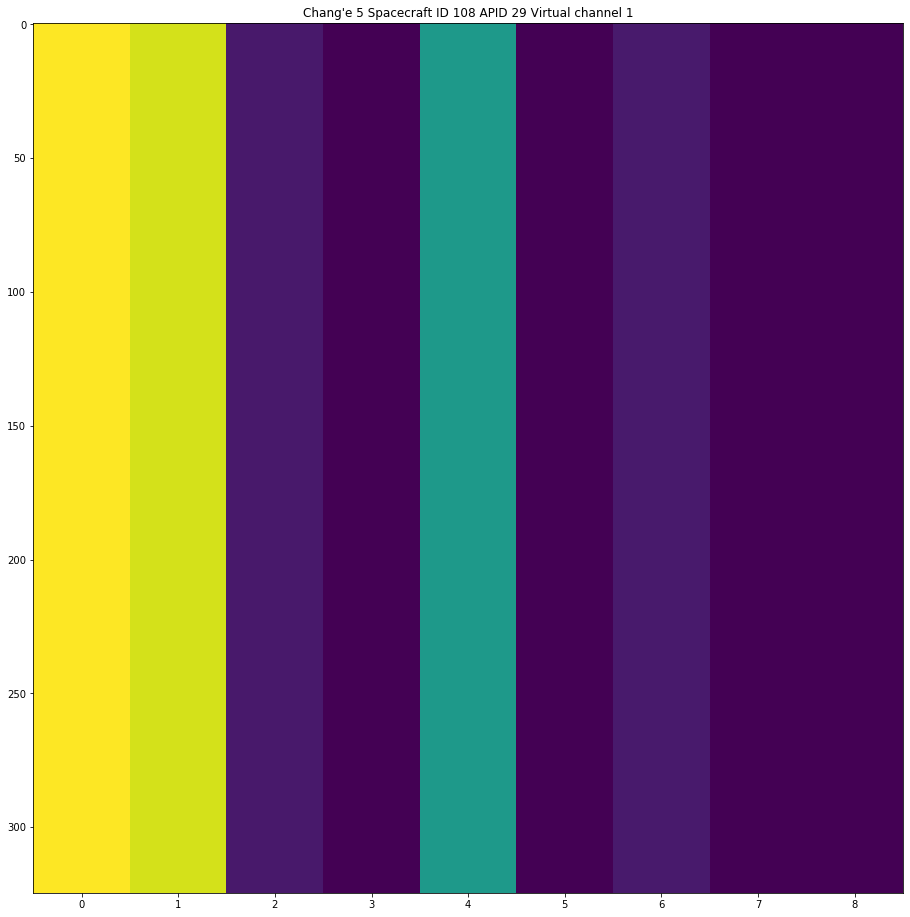

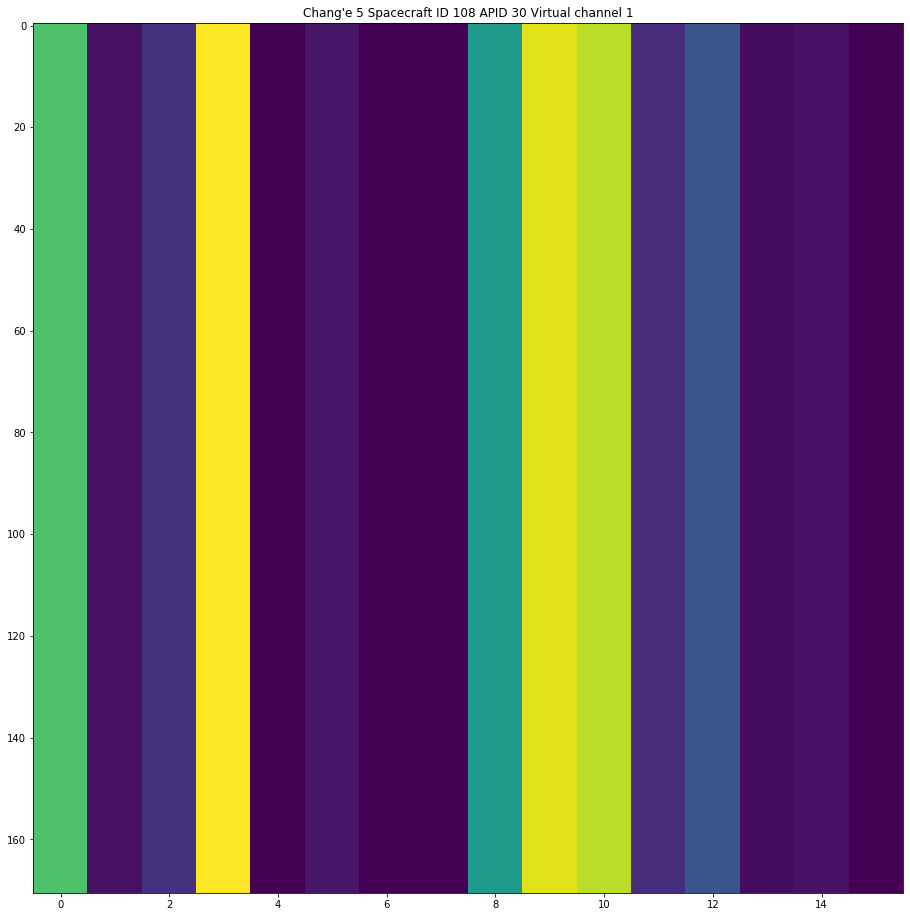

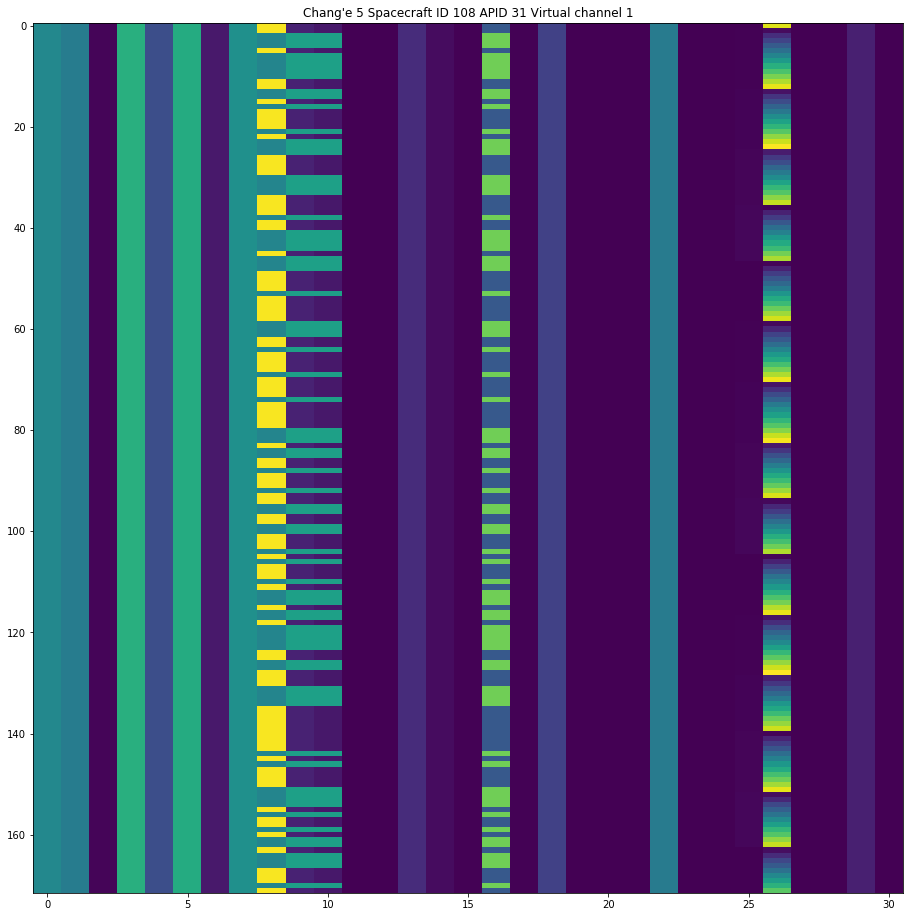

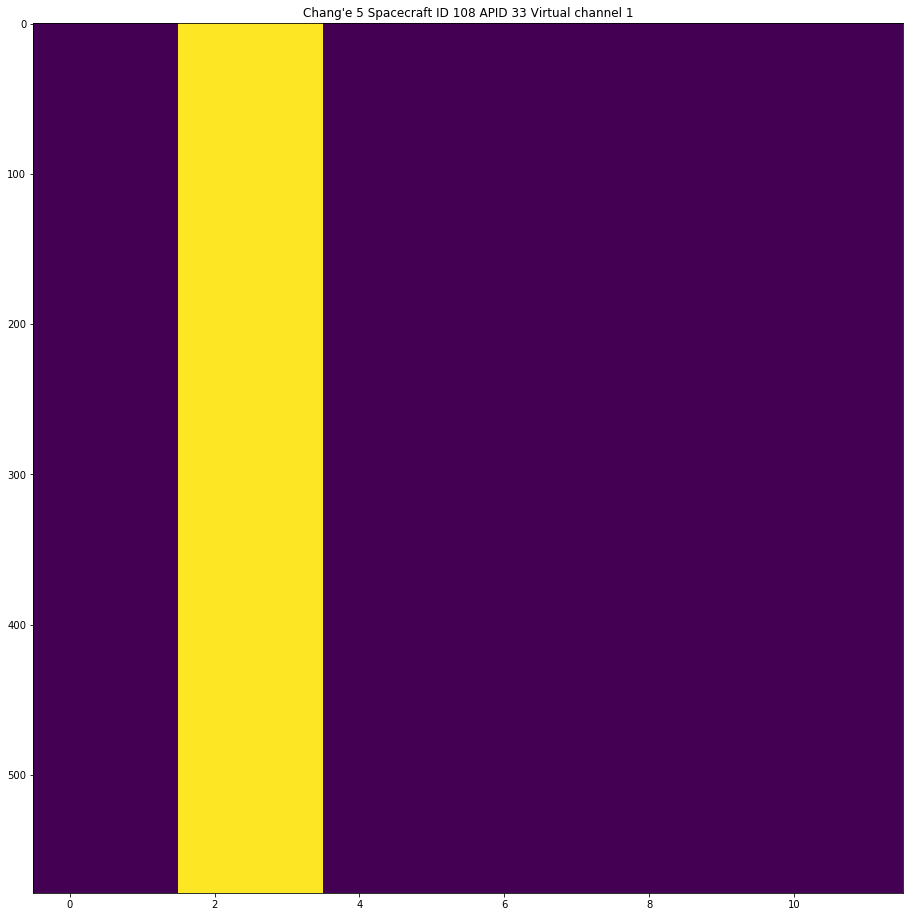

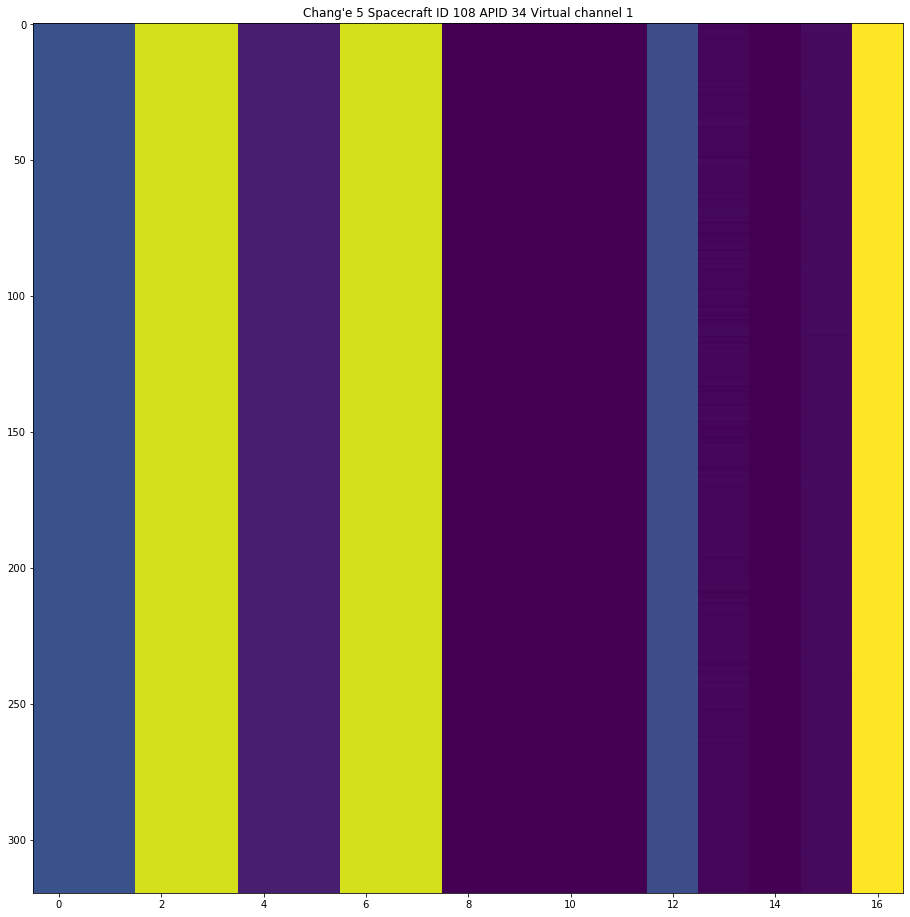

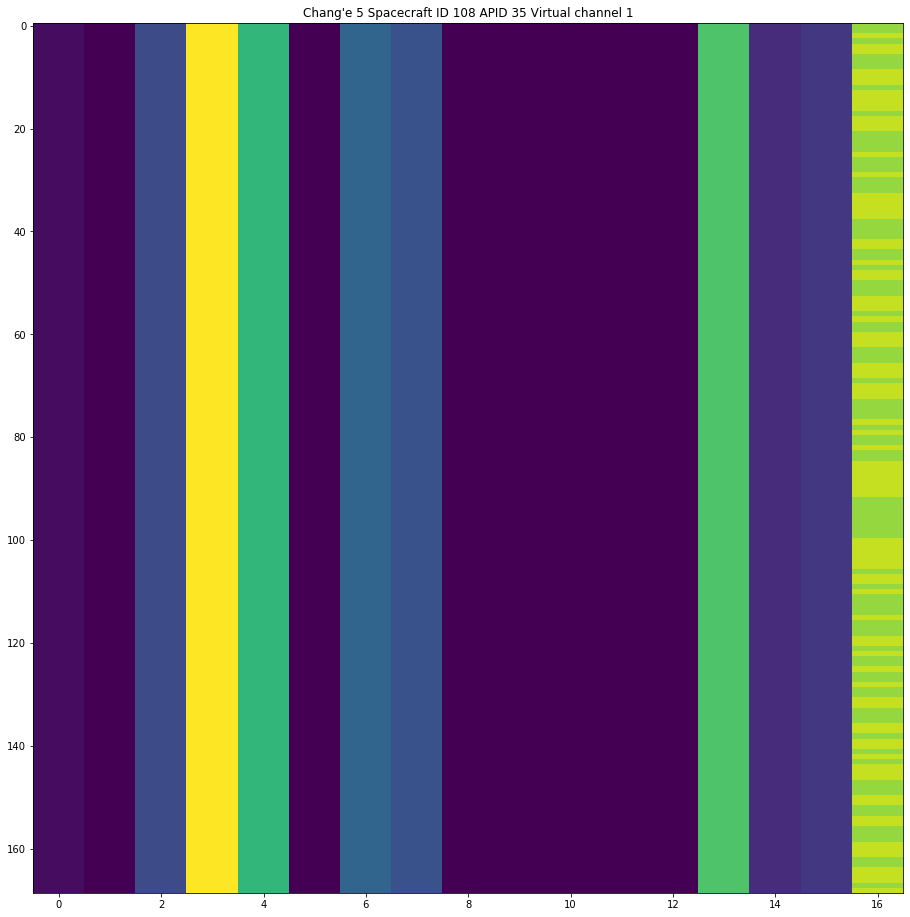

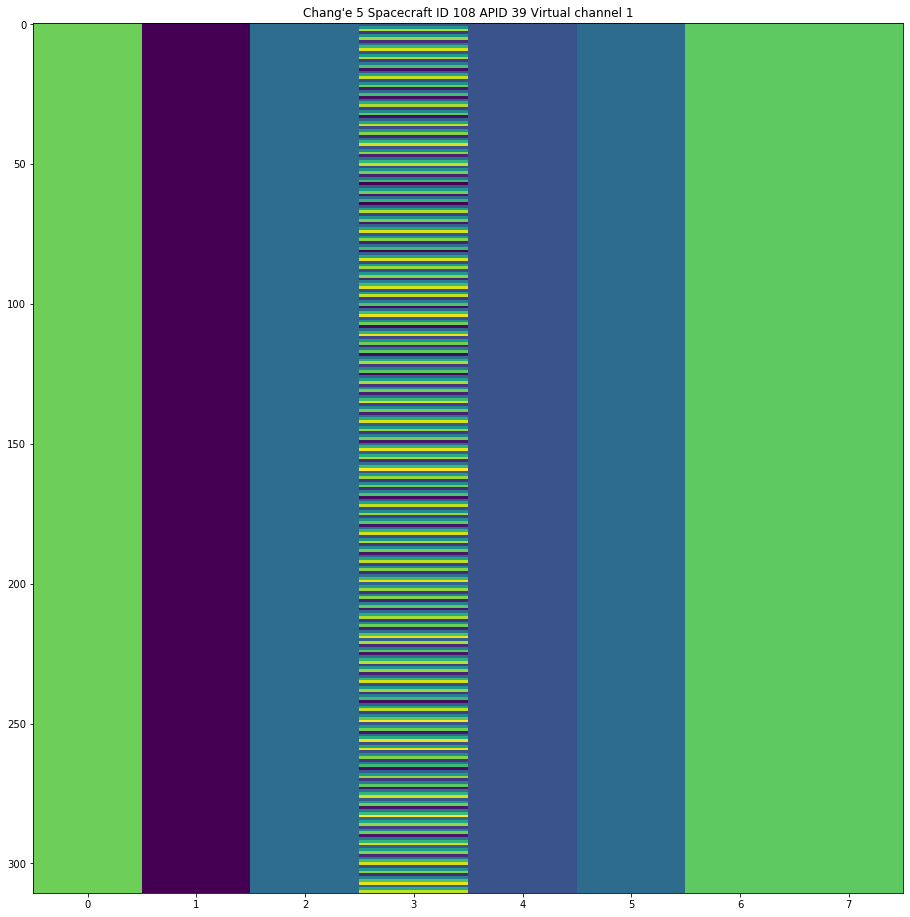

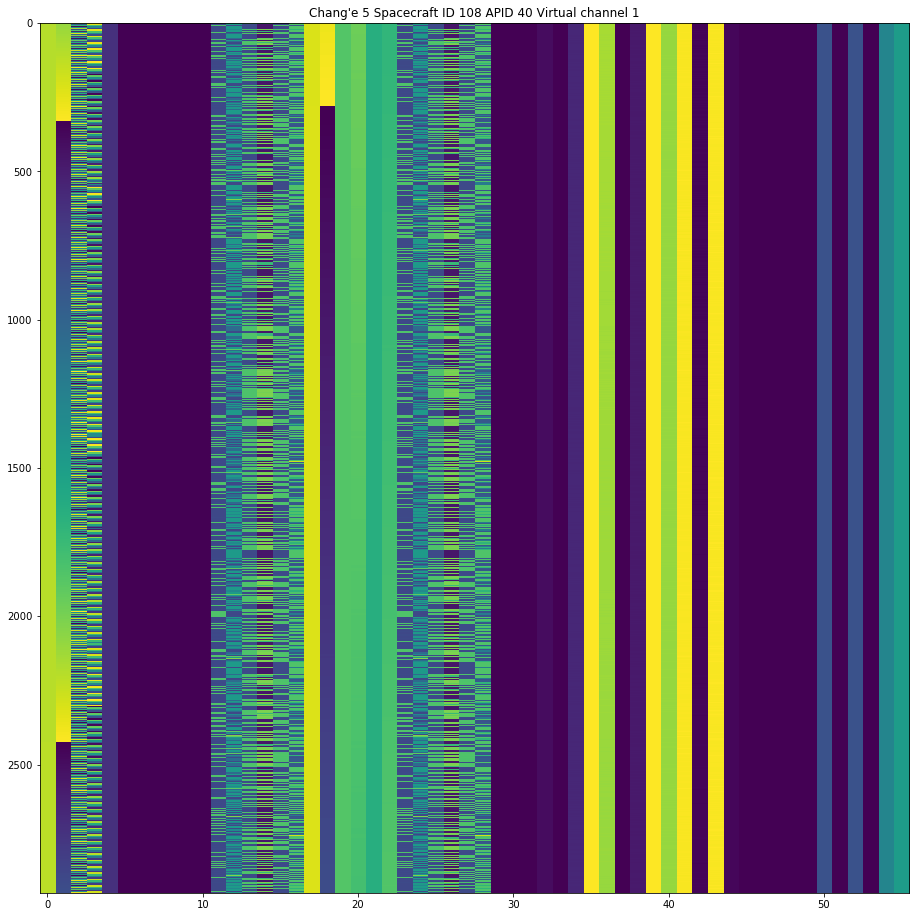

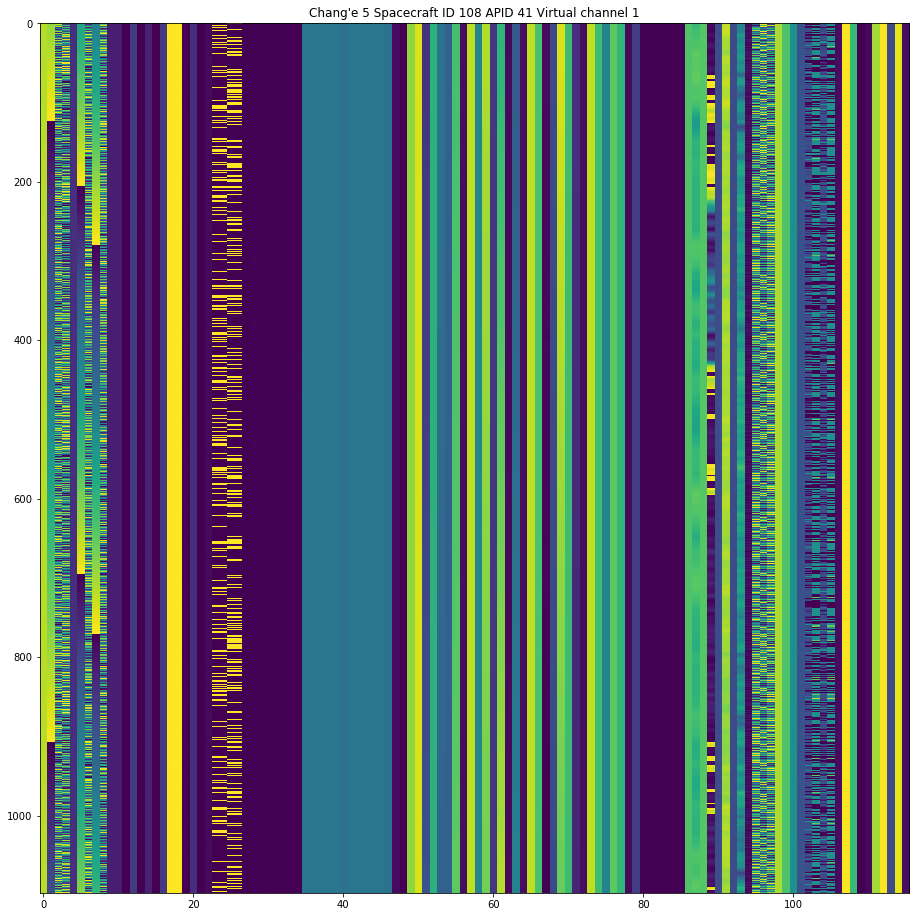

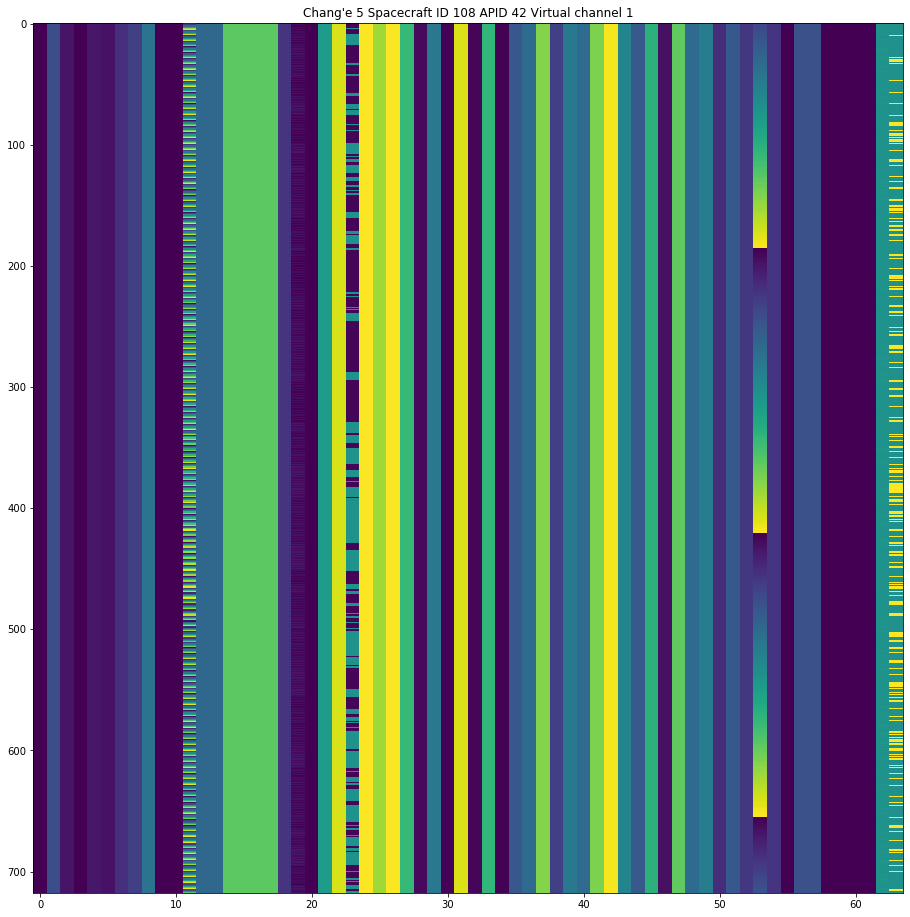

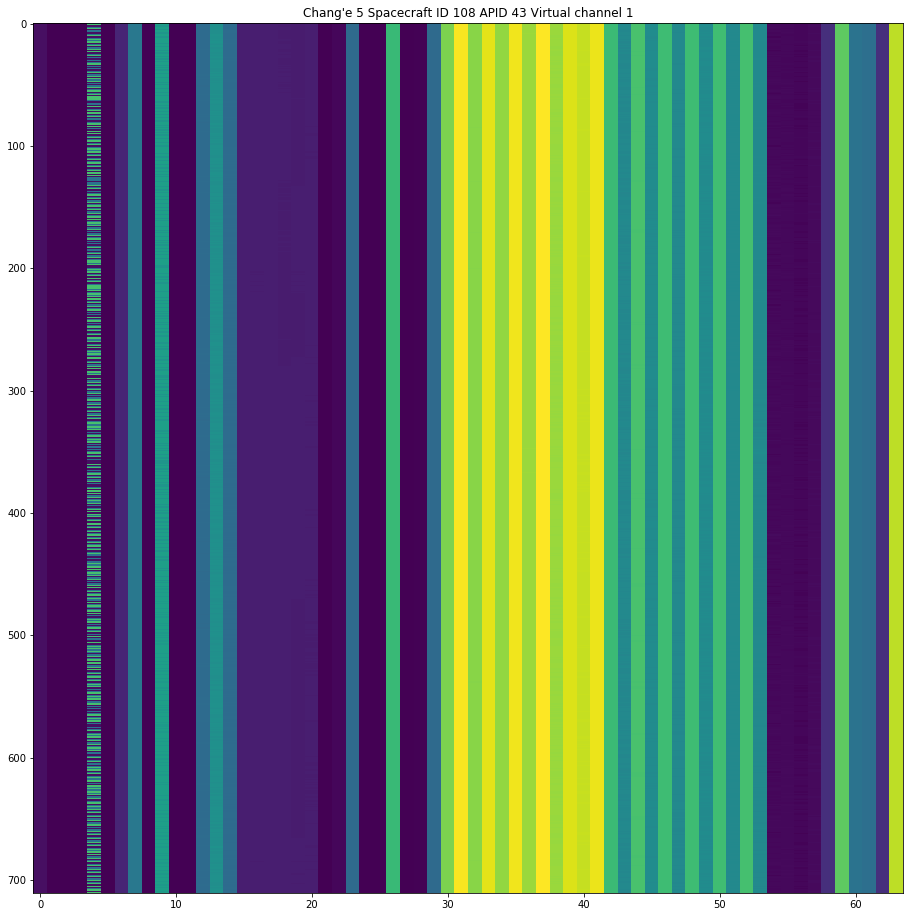

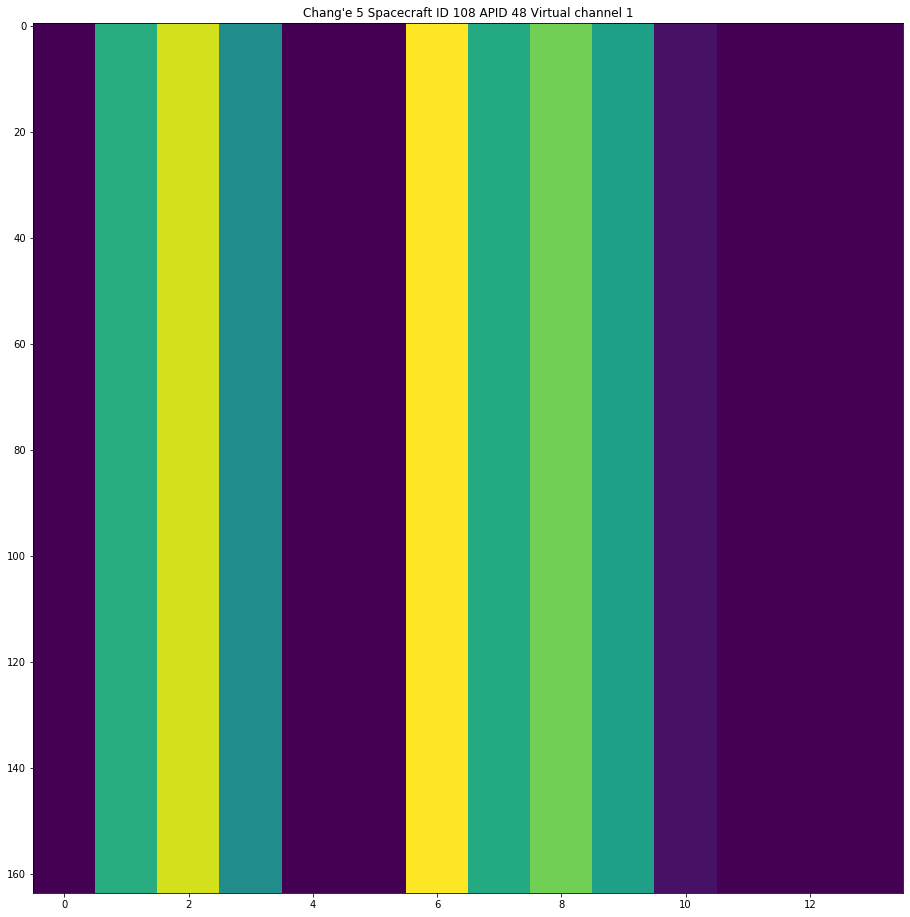

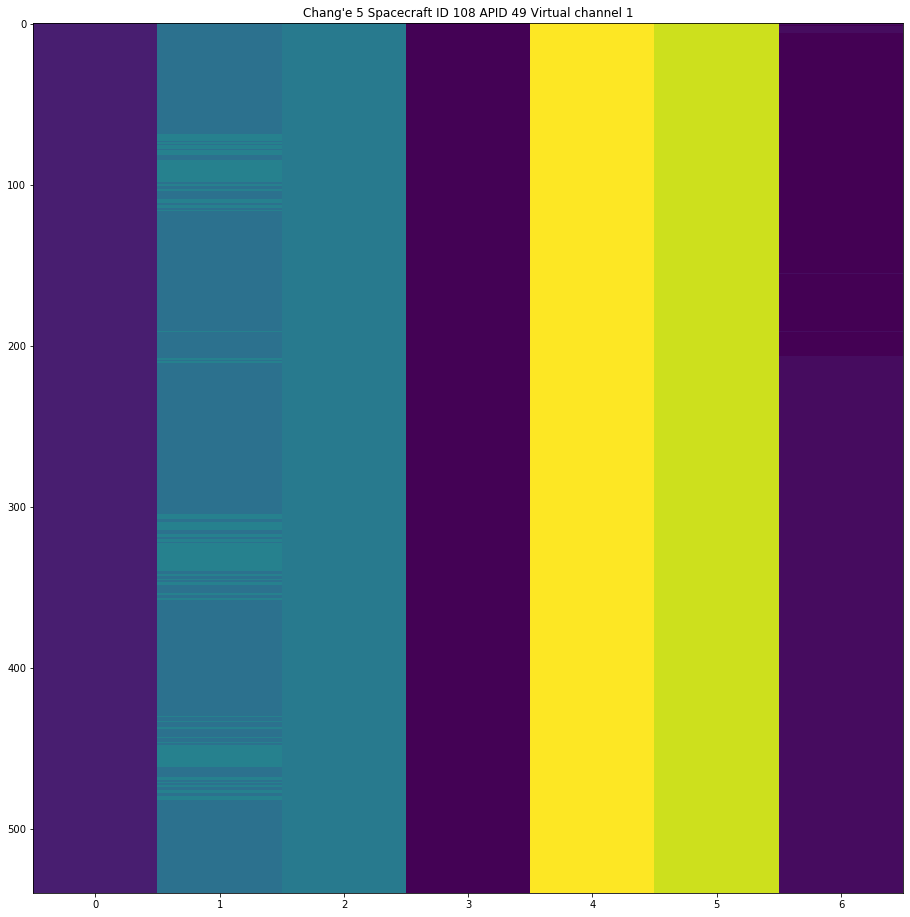

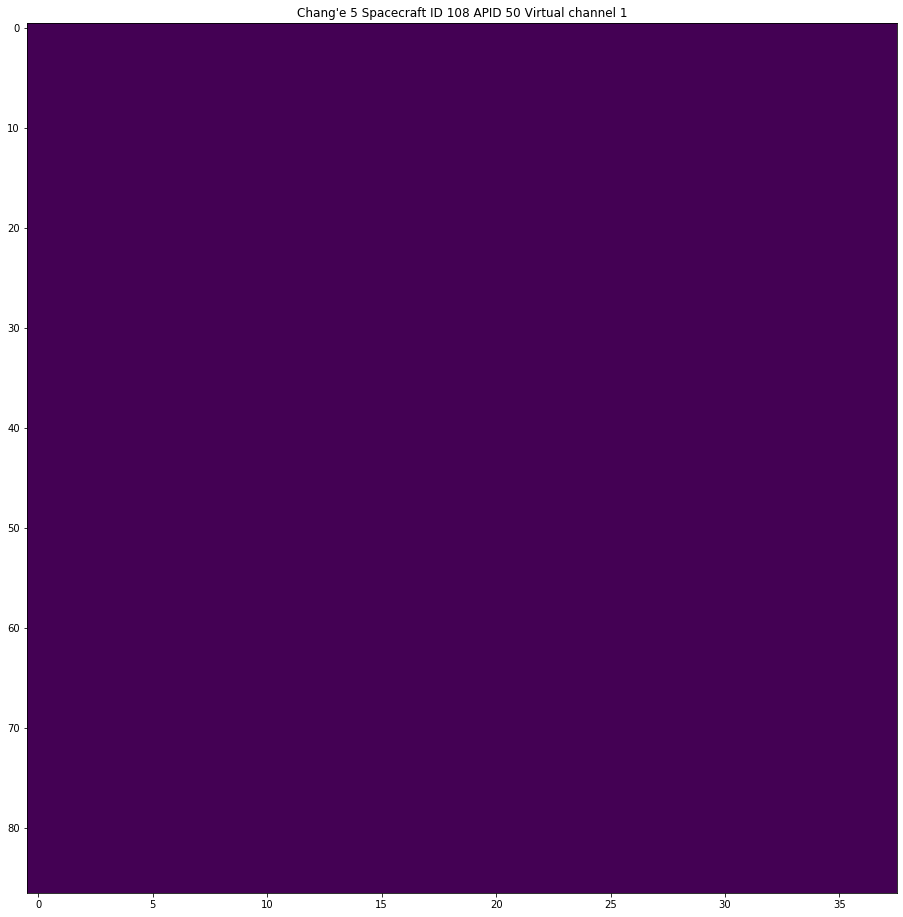

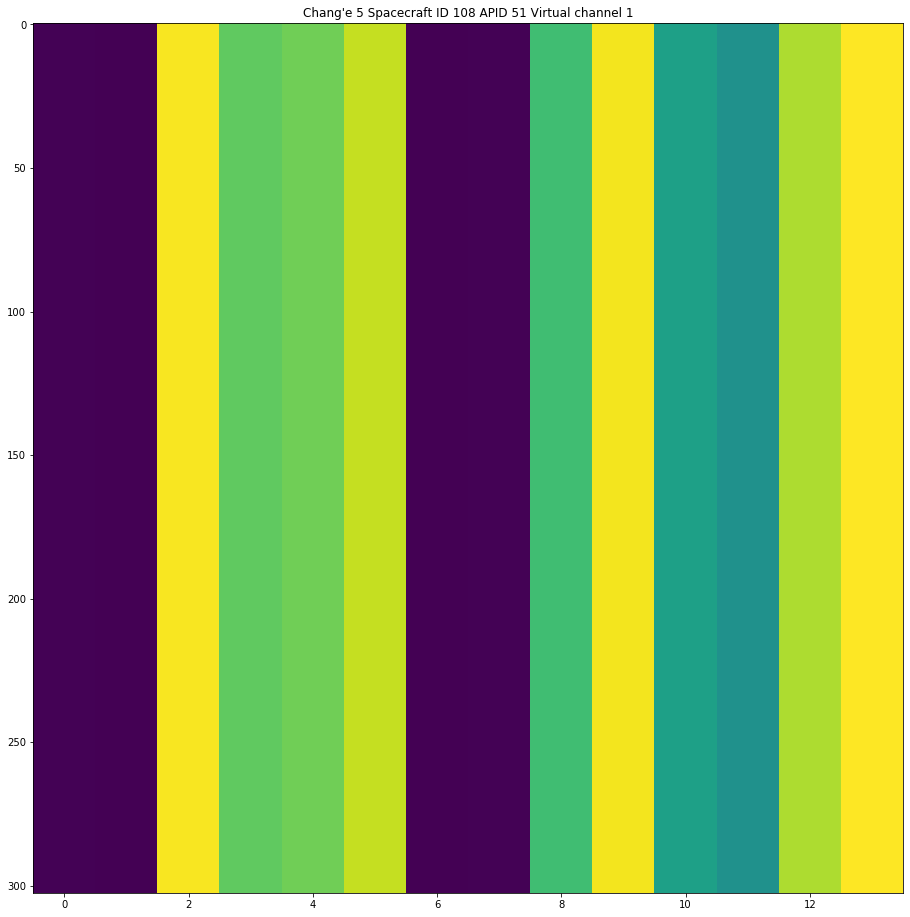

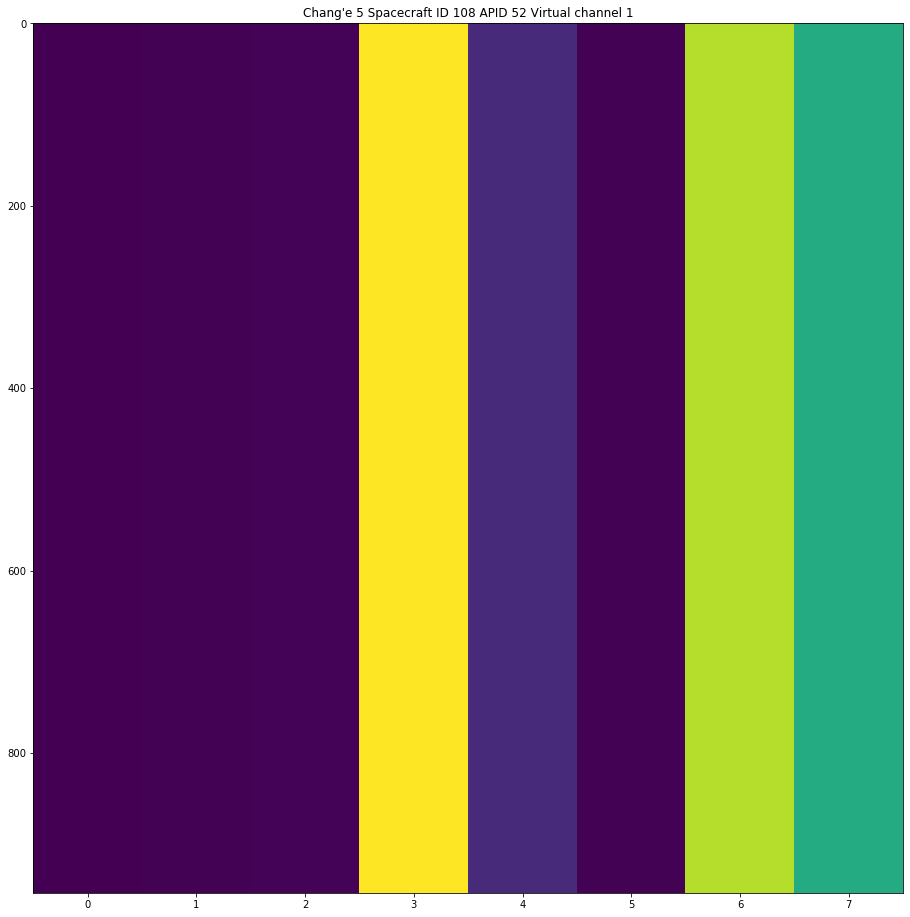

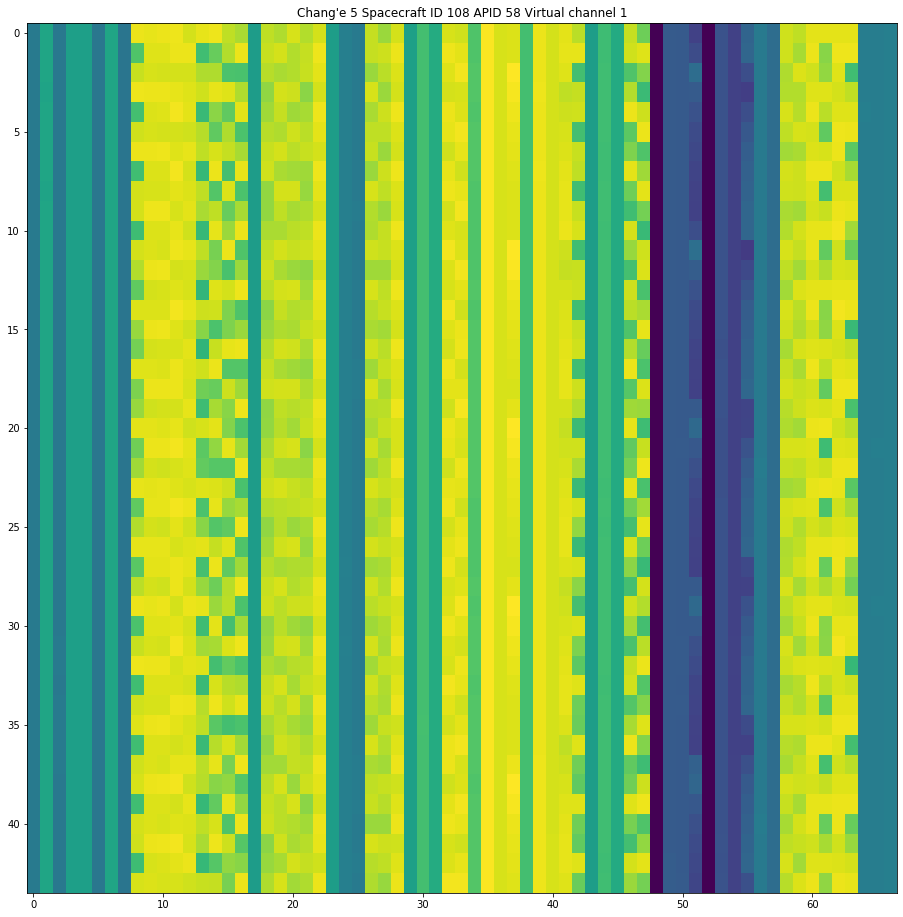

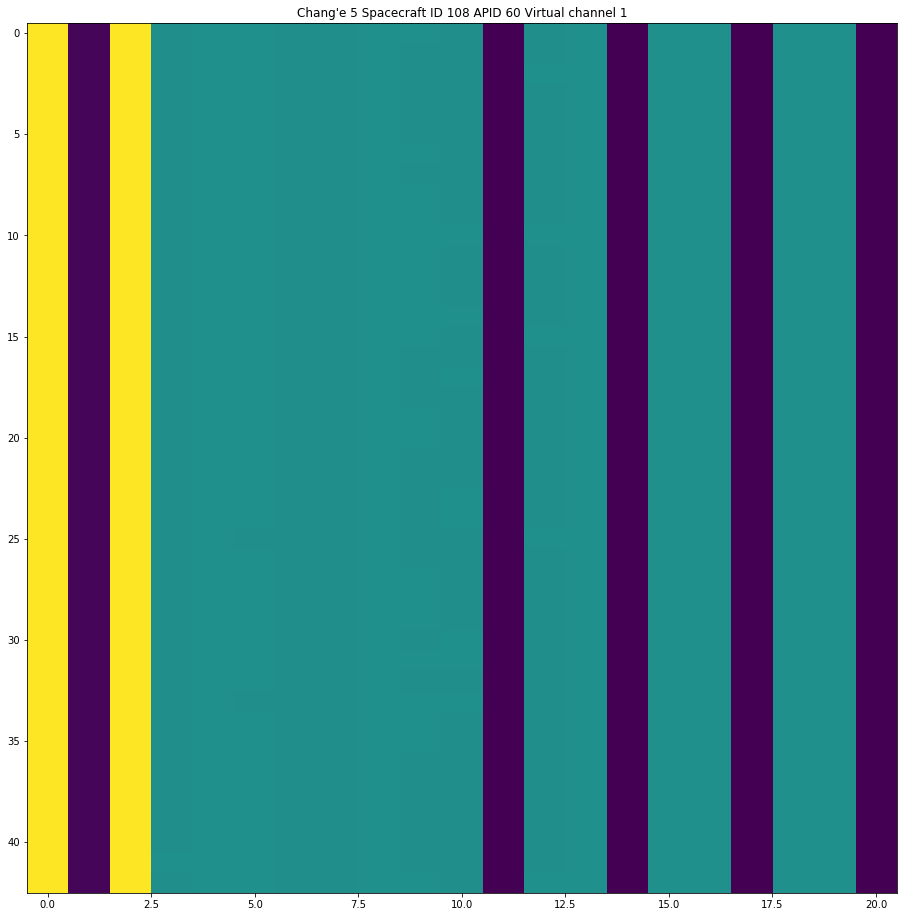

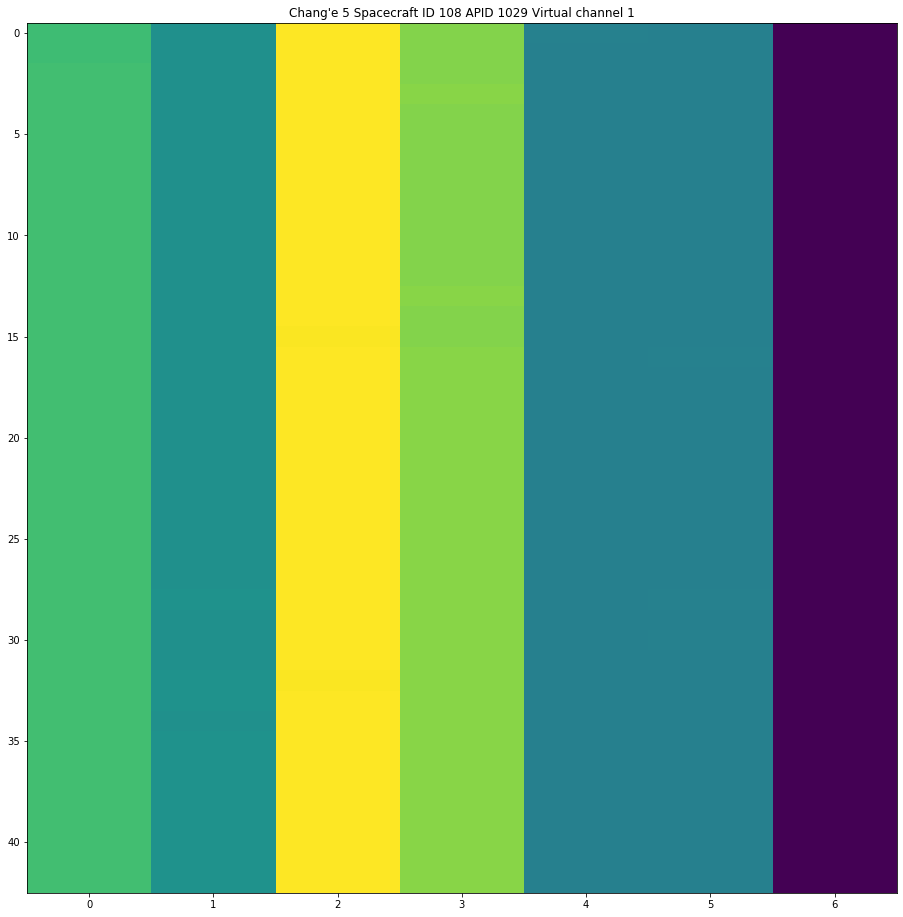

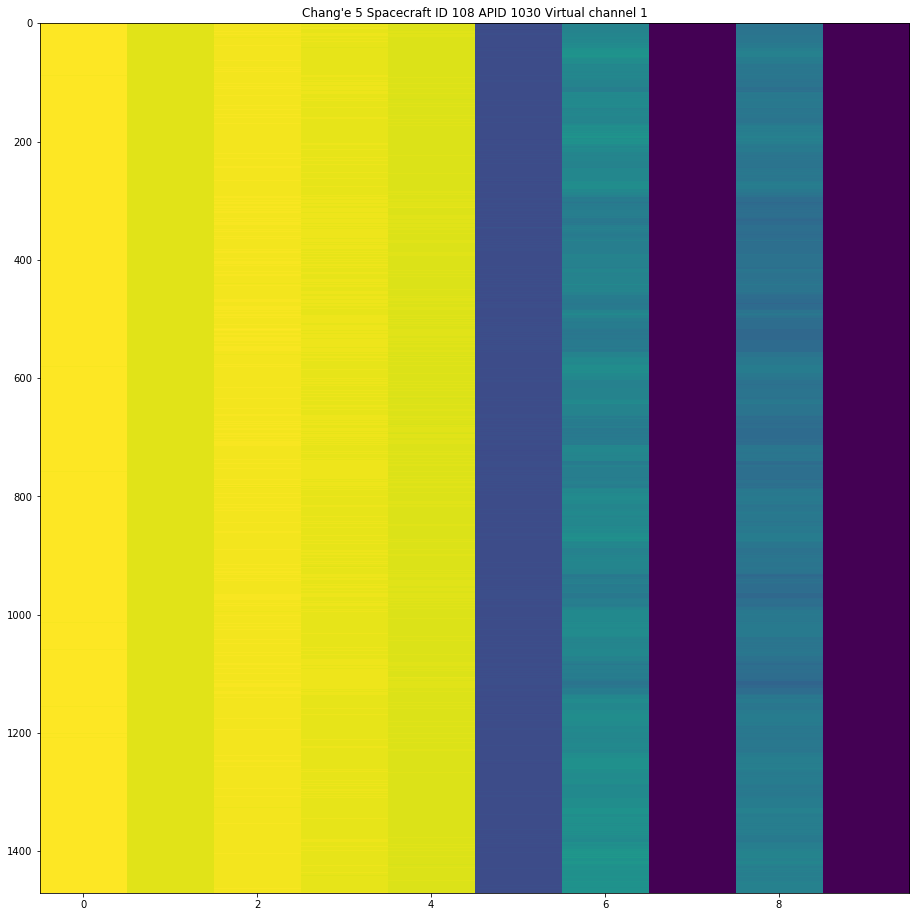

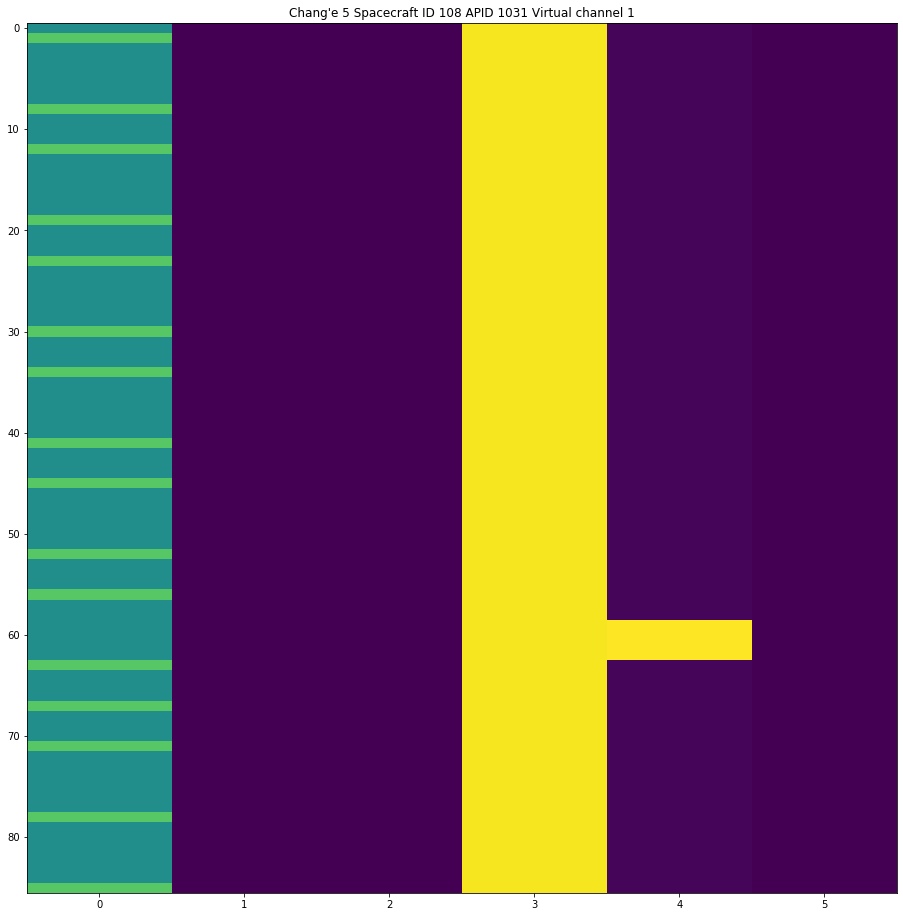

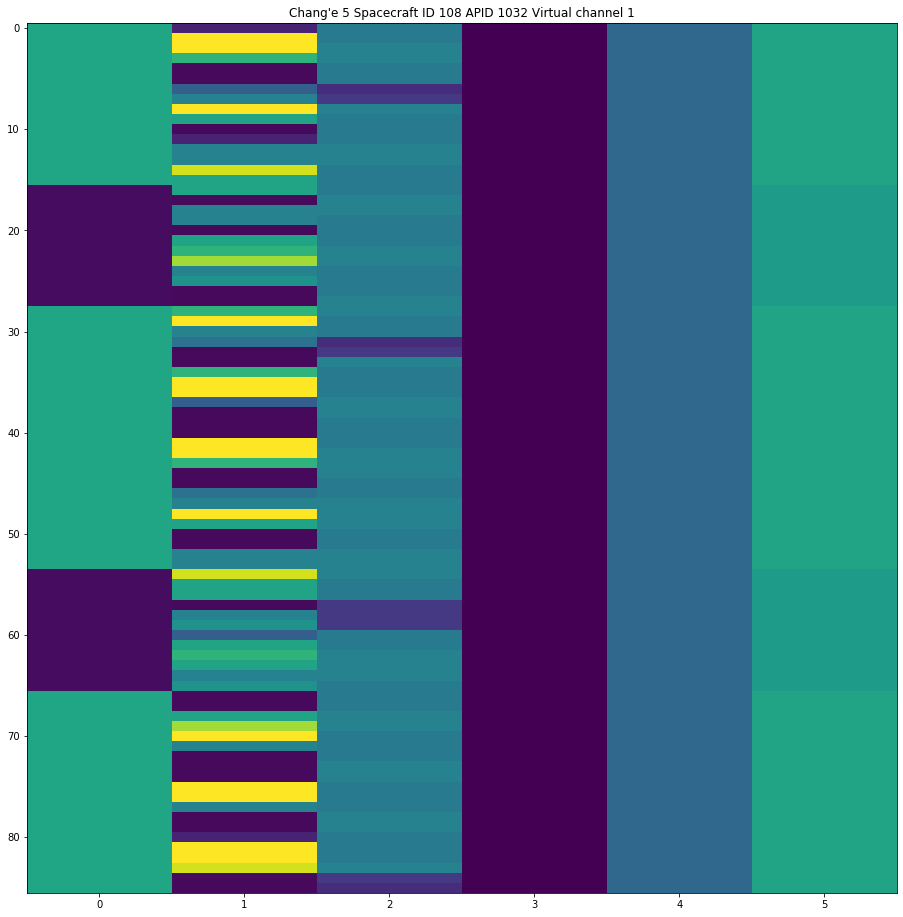

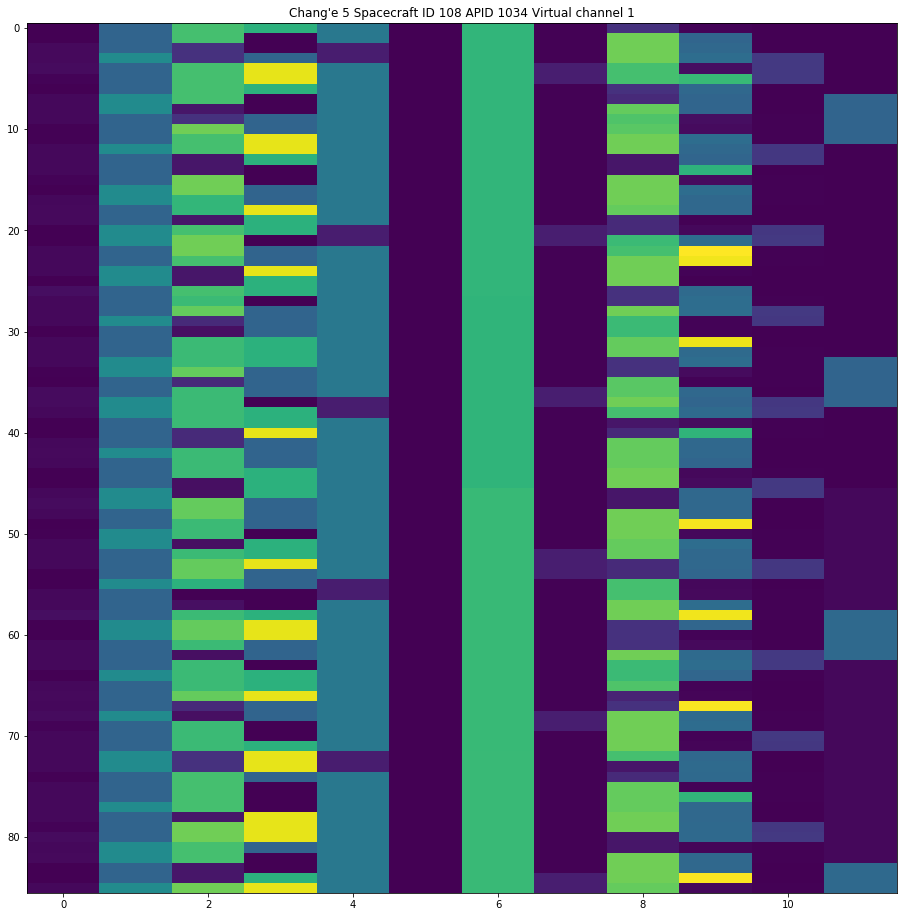

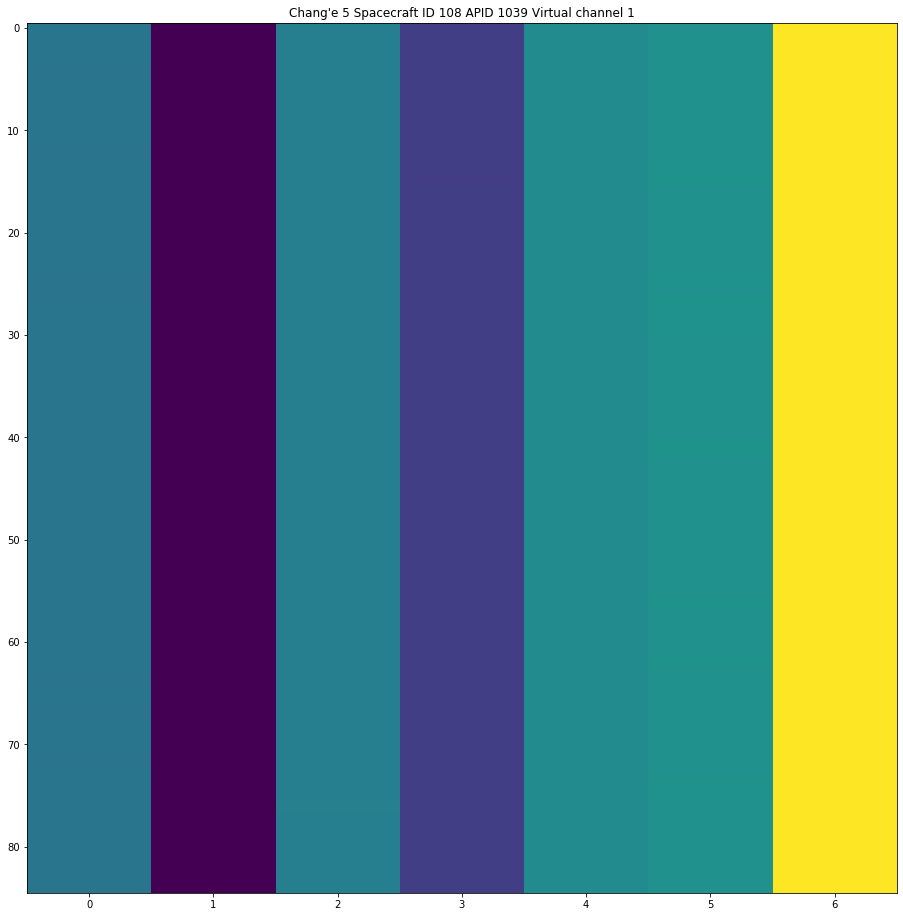

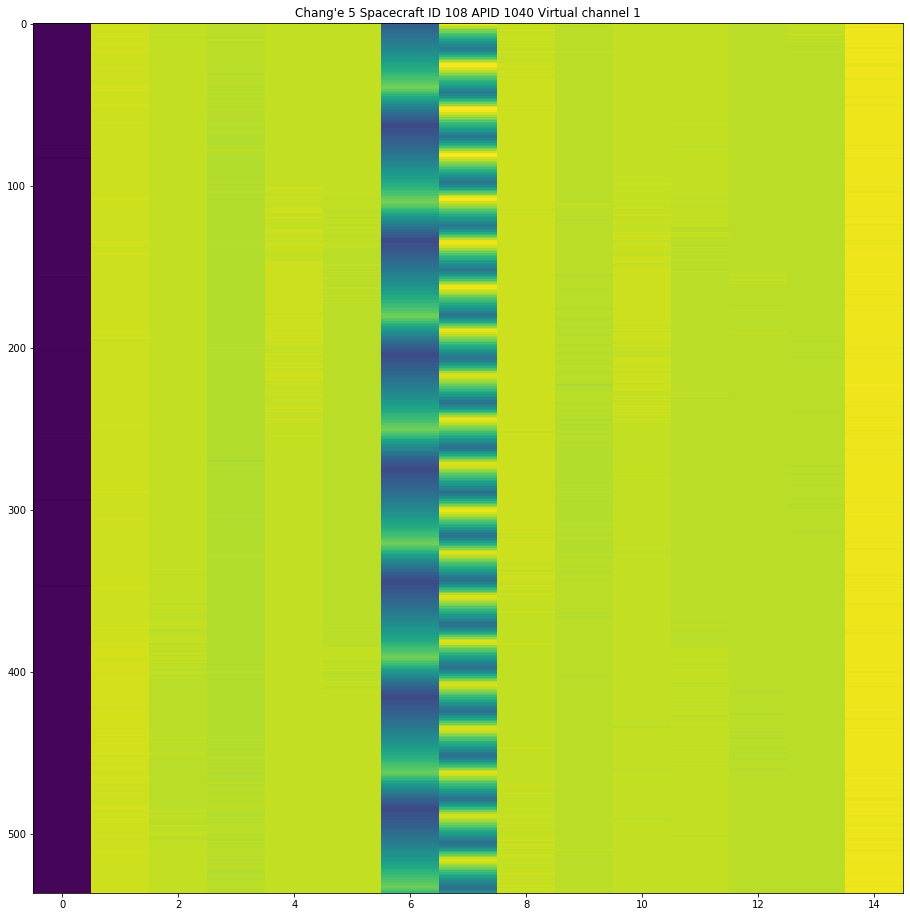

In [20]:
plot_apids(vc1_by_apid, 108, 1)